In [1]:
!pip install medmnist
!pip install matplotlib
!pip install torch
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.0 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

In [2]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 28.2 MB/s eta 0:00:00


In [3]:
import medmnist
from medmnist import INFO, Evaluator
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import utils
from torch import optim
from torch import device
from torch import inference_mode
import tqdm
from timeit import default_timer as timer
from tqdm.auto import tqdm
from torchmetrics import ConfusionMatrix
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
import numpy

In [4]:
data_flag = 'pathmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_data = DataClass(split='train', transform=data_transform, download=True)
val_data = DataClass(split='val', transform=data_transform, download=True)
test_data = DataClass(split='test', transform=data_transform, download=True)

100%|██████████| 206M/206M [00:08<00:00, 24.6MB/s]


Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


In [5]:
# check data properties
img = train_data[0][0]
label = train_data[0][1]

print(f"Image:\n {img}")
print(f"Label:\n {label}")

print(f"Image shape: {img.shape}")
print(f"Label: {label}")

Image:
 tensor([[[0.7255, 0.7176, 0.7255,  ..., 0.7255, 0.7176, 0.7333],
         [0.7098, 0.7255, 0.7176,  ..., 0.5451, 0.5059, 0.4902],
         [0.7255, 0.7255, 0.7176,  ..., 0.6314, 0.6235, 0.6392],
         ...,
         [0.7098, 0.7020, 0.7333,  ..., 0.7333, 0.7255, 0.7333],
         [0.6706, 0.7020, 0.7333,  ..., 0.7333, 0.7333, 0.7333],
         [0.6863, 0.7255, 0.7333,  ..., 0.7255, 0.7333, 0.7412]],

        [[0.6314, 0.6235, 0.6235,  ..., 0.6314, 0.6235, 0.6314],
         [0.6157, 0.6235, 0.6157,  ..., 0.3882, 0.3490, 0.3176],
         [0.6314, 0.6235, 0.6078,  ..., 0.4980, 0.5059, 0.5216],
         ...,
         [0.6078, 0.5765, 0.6314,  ..., 0.6314, 0.6314, 0.6392],
         [0.5059, 0.5686, 0.6314,  ..., 0.6314, 0.6392, 0.6314],
         [0.5294, 0.6235, 0.6314,  ..., 0.6314, 0.6314, 0.6392]],

        [[0.7804, 0.7804, 0.7804,  ..., 0.7804, 0.7804, 0.7804],
         [0.7725, 0.7725, 0.7725,  ..., 0.5843, 0.5451, 0.5294],
         [0.7725, 0.7725, 0.7647,  ..., 0.6706, 0.

In [6]:
# Number of image channels
n_channels = info['n_channels']
print(f"number of channels: {n_channels}")

# Number of classes
n_classes = len(info['label'])
print(f"number of classes: {n_classes}")

# Get the class names from the dataset
class_names = info['label']
print(f"class names: {class_names}")

number of channels: 3
number of classes: 9
class names: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}


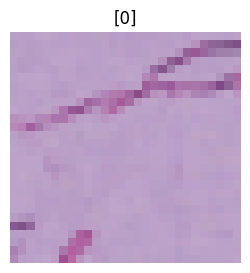

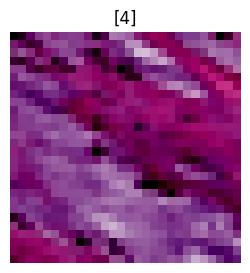

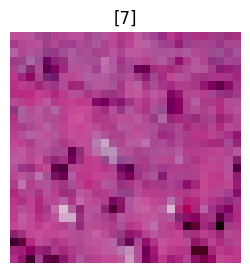

In [7]:
for i in range(3):
    img = train_data[i][0]
    label = train_data[i][1]
    plt.figure(figsize=(3, 3))
    plt.imshow(img.permute(1, 2, 0))
    plt.title(label)
    plt.axis(False);

In [8]:
import numpy as np
import torch
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Assuming 'train_data' is the PathMNIST dataset and 'test_data' is the test data

x_train = []
y_train = []
x_test = []
y_test = []

# Loop through the training data to flatten the images and collect labels
for img, label in train_data:
    flattened_image = img.flatten()  # Flatten the image into a 1D array
    x_train.append(flattened_image)
    y_train.append(label)

# Loop through the test data to flatten the images and collect labels
for img, label in test_data:
    flattened_image = img.flatten()  # Flatten the image into a 1D array
    x_test.append(flattened_image)
    y_test.append(label)

# Convert to numpy arrays for compatibility with scikit-learn
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# Example: calculate the mean and variance of each image
means = np.mean(x_train, axis=1)
variances = np.var(x_train, axis=1)
x_train_with_stats = np.column_stack((x_train, means, variances))
x_test_with_stats = np.column_stack((x_test, np.mean(x_test, axis=1), np.var(x_test, axis=1)))




In [9]:
x_train = np.array(x_train)
y_train = np.array(y_train)

print(f"Shape of x_train (after flattening): {x_train[0]}")

Shape of x_train (after flattening): [0.7254902  0.7176471  0.7254902  ... 0.78039217 0.78039217 0.7882353 ]


2352


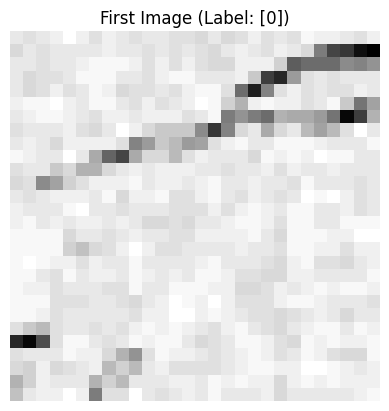

In [10]:
image_reshaped = x_train[0].reshape(3, 28, 28)  # 3 channels, 28x28 pixels
print(image_reshaped.size)

# Plot the image for visualization (using the first channel or all channels)
plt.imshow(image_reshaped[0], cmap='gray')  # Show the first channel (grayscale)
plt.title(f"First Image (Label: {y_train[0]})")
plt.axis('off')  # Turn off axis for better visualization
plt.show()

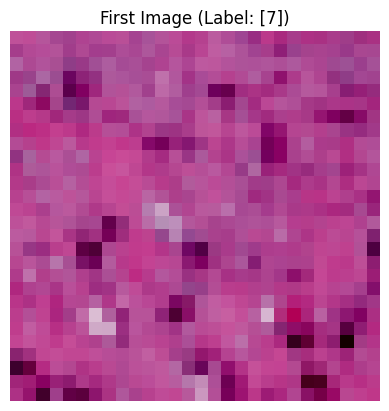

In [11]:
image_resized = x_train[2].reshape(3, 28, 28)  # Assuming it's a 28x28 image with 3 channels

# Show the full 3-channel image (colored)
plt.imshow(np.transpose(image_resized, (1, 2, 0)))  # Transpose to (height, width, channels)
plt.title(f"First Image (Label: {y_train[2]})")
plt.axis('off')
plt.show()